<a href="https://colab.research.google.com/github/marcondesc/mcws_wasa/blob/main/Coocorr%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise bibliográfica


### Carregar os dados e importar as bibliotecas

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Baixar stopwords se ainda não estiverem disponíveis
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Definir as stop words
#stop_words = set(stopwords.words('portuguese'))
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Carregar arquivo csv
df = pd.read_csv('/content/scopus_1_418_docs.csv')

In [ ]:
compound_terms = ["artificial intelligence",
"automotive industria",
"Bibliometrics analysis",
"bimodal it",
"blockchain technology",
"blockchain technology",
"business analytics",
"Business models",
"case study",
"citizens",
"covid 19",
"competency framework",
"consent management",
"contractual governance",
"corporate governance",
"cyber security",
"Cyber-physical systems",
"data analytics",
"decision making",
"digital governance",
"digital government",
"digital technology",
"digital transformation",
"Digital plataforms",
"digital twins",
"it governance",
"enterprise architecture management",
"European Union",
"future of welfare",
"future of work",
"e-governance",
"industry 4.0",
"communication technology",
"information and communication technology",
"industrial internet of things",
"institutional theory",
"internet of things",
"literature review",
"maturity model",
"open data",
"platform work",
"public governance",
"qualitative study",
"research agenda",
"robotic process automation",
"saudi arabia",
"science base",
"it security",
"smart city",
"smart factories",
"South Africa",
"social innovation",
"social protection system",
"social services",
"software development",
"strategic alignment",
"strategy",
"subnational government",
"technology  technologies",
"university 4.0",
"value chain",
"welfare society",
"welfare system",
"digital india"]


### Artigos publicados por ano

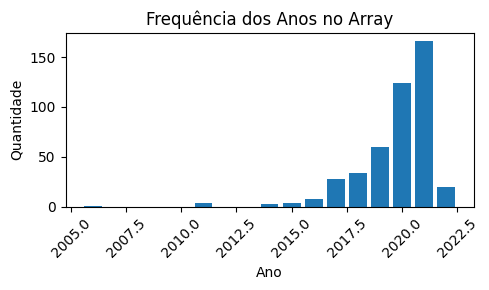

In [ ]:
years = df['Year'].astype(int)

# Contar a quantidade de vezes que cada ano aparece
year_counts = Counter(years)

# Separar os dados para o gráfico
anos = list(year_counts.keys())
quantidades = list(year_counts.values())

# Criar o gráfico de barras
plt.figure(figsize=(5, 3))  # Define o tamanho da figura
plt.bar(anos, quantidades)   # Plota as barras

# Adicionar títulos e rótulos
plt.title('Frequência dos Anos no Array')  # Título do gráfico
plt.xlabel('Ano')                          # Rótulo do eixo x
plt.ylabel('Quantidade')                   # Rótulo do eixo y

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Ajustar o layout para que os rótulos não fiquem cortados
plt.tight_layout()

# Exibir o gráfico
plt.show()

### Processamento do texto

In [ ]:
def preprocess_text(text, stop_words):
    # Converter para minúsculas
    text = text.lower()
    # Remover pontuação
    text = re.sub(r'[^\w\s]', '', text)
    # Remover stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # tokenização
    tokens = nltk.word_tokenize(text)
    # lematização
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [ ]:
df['Title'] = df['Title'].apply(lambda x: preprocess_text(x, stop_words))

In [ ]:
df['Title']

,Title
0,"[development, assessment, model, industry, 40,..."
1,"[webenabled, supply, chain, management, key, a..."
2,"[consumerization, transformation, governance]"
3,"[egovernment, canada, transformation, digital,..."
4,"[digital, transformation, latecomer, industry,..."
...,...
447,"[standing, conference, eastern, central, south..."
448,"[lecture, note, informatics, lni, proceeding, ..."
449,"[territory, tourist, area, ending, illusion, d..."
450,"[periklis, electronic, democracy, 21st, century]"


In [ ]:
# Função para restaurar termos compostos in-place
def restore_compound_terms_in_place(tokens, compound_terms):
    compound_dict = {tuple(term.split()): term for term in compound_terms}
    i = 0
    while i < len(tokens):
        match_found = False
        for compound_words in compound_dict.keys():
            if tokens[i:i+len(compound_words)] == list(compound_words):
                tokens[i:i+len(compound_words)] = [compound_dict[compound_words]]
                match_found = True
                break
        i += 1 if not match_found else len(compound_words)
    return tokens


In [ ]:
# Aplicar a função a cada registro do DataFrame
df_compound_terms['Title'] = df['Title'].apply(lambda tokens: restore_compound_terms_in_place(tokens, compound_terms))

# Mostrar o DataFrame com os termos compostos restaurados
print("DataFrame com termos compostos restaurados:\n", df_compound_terms)

DataFrame com termos compostos restaurados:
 0        [development, assessment, model, industry, 40,...
1        [webenabled, supply, chain, management, key, a...
2            [consumerization, transformation, governance]
3        [egovernment, canada, transformation, digital,...
4        [digital transformation, latecomer, industry, ...
                               ...                        
448      [lecture, note, informatics, lni, proceeding, ...
449      [territory, tourist, area, ending, illusion, d...
450       [periklis, electronic, democracy, 21st, century]
451      [enterprise, business, technology, governance,...
Title    0      [development, assessment, model, indust...
Name: Title, Length: 453, dtype: object


In [ ]:
# Função para gerar uma matriz de coocorrência a partir de um DataFrame com tokens
def generate_cooccurrence_matrix_from_dataframe(df, text_column):
    texts = [" ".join(tokens) for tokens in df[text_column]]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    cooc_matrix = (X.T * X)
    cooc_matrix.setdiag(0)
    cooc_matrix_df = pd.DataFrame(cooc_matrix.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
    return cooc_matrix_df

In [ ]:
# Gerar a matriz de coocorrência a partir do DataFrame
cooc_matrix_df = generate_cooccurrence_matrix_from_dataframe(df_compound_terms, 'Title')

### Grafo de Coocorrência de Termos

In [ ]:
def plot_cooccurrence_graph(cooc_matrix_df, threshold=1, k_value=1.5):
    # Cria o grafo
    G = nx.Graph()

    # Adiciona arestas ao grafo com base na matriz de coocorrência e no limiar (threshold)
    for i in range(len(cooc_matrix_df)):
        for j in range(i + 1, len(cooc_matrix_df)):
            if cooc_matrix_df.iat[i, j] >= threshold:  # Adiciona se a coocorrência for maior ou igual ao limiar
                G.add_edge(cooc_matrix_df.index[i], cooc_matrix_df.columns[j], weight=cooc_matrix_df.iat[i, j])

    # Desenhar o grafo com o layout de primavera (spring layout) e k ajustado
    pos = nx.spring_layout(G, seed=42, k=k_value)
    plt.figure(figsize=(16, 12))

    # Desenhar os nós e as arestas
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.3 for u, v in G.edges()], alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    # Exibir o peso das arestas (frequência de coocorrência)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Grafo de Coocorrência de Termos")
    plt.show()

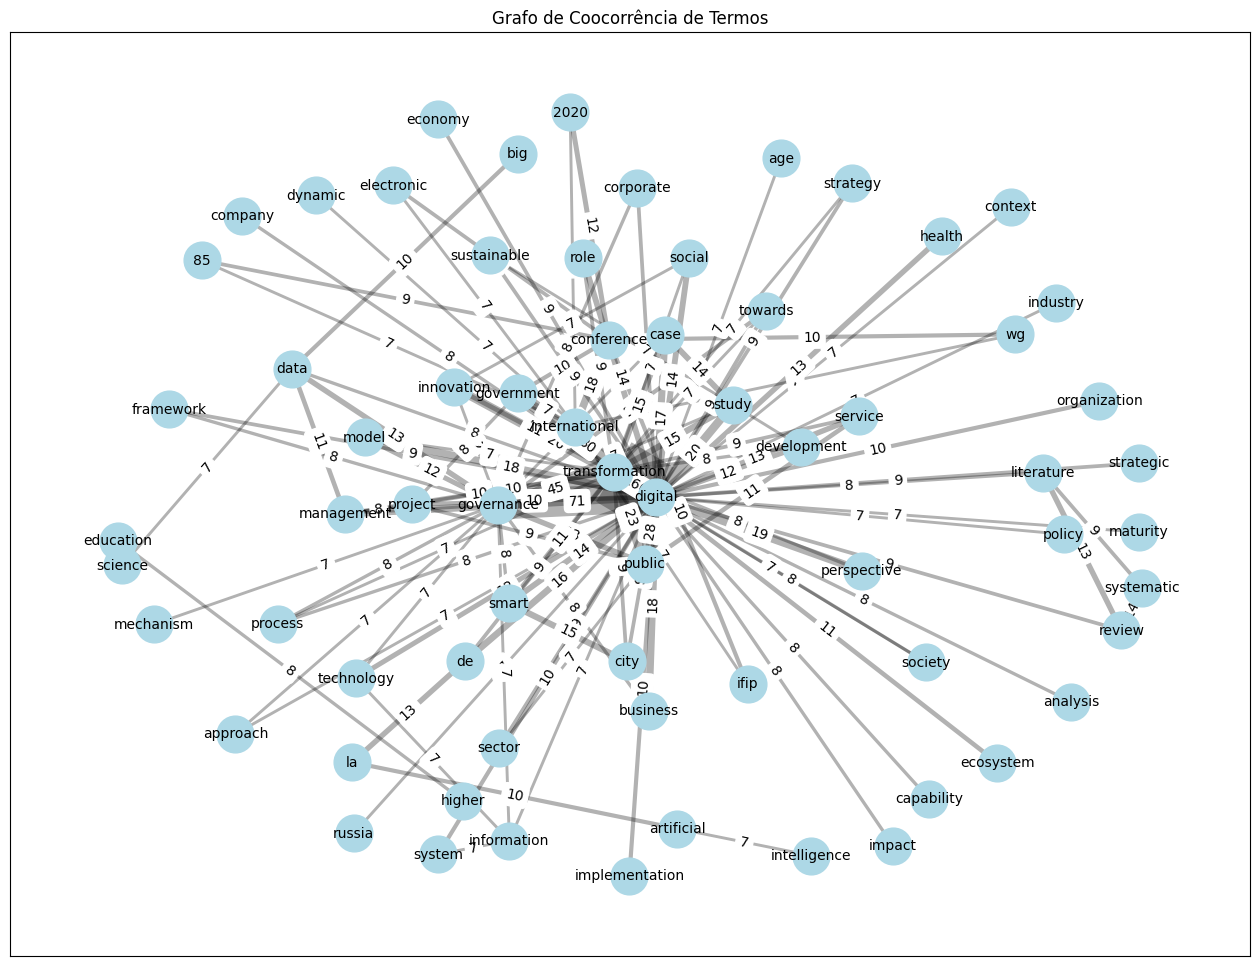

In [ ]:
# Plotar a matriz de coocorrência como um grafo
plot_cooccurrence_graph(cooc_matrix_df, threshold=7, k_value=1.8)

### Nuvem de Palavras

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
def generate_word_cloud_from_dataframe(df, text_column, stop_words=None):
    # Unir todas as listas de tokens em uma string única
    combined_text = " ".join([" ".join(tokens) for tokens in df[text_column]])

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(combined_text)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

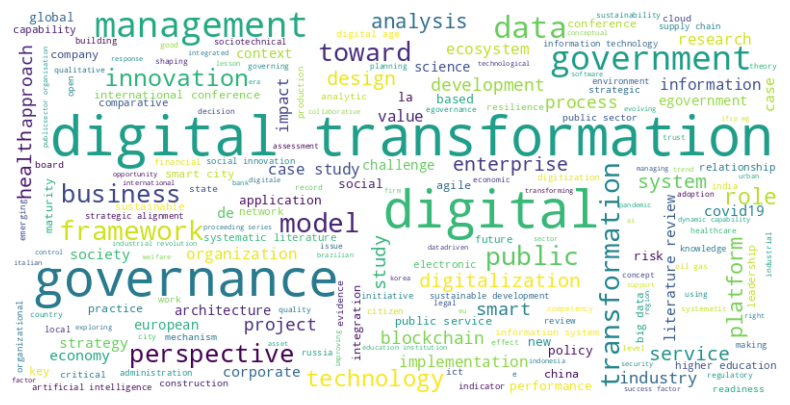

In [ ]:
generate_word_cloud_from_dataframe(df_compound_terms, 'Title')

### Gráfico dos termos mais frequentes

In [ ]:
# Função para contar os termos e plotar os 20 mais frequentes
def plot_top_20_terms(df, text_column):
    # Unir todas as listas de tokens em uma única lista de palavras
    all_tokens = [token for tokens_list in df[text_column] for token in tokens_list]

    # Contar a frequência de cada termo
    term_counts = Counter(all_tokens)

    # Selecionar os 20 termos mais comuns
    most_common_terms = term_counts.most_common(20)

    # Separar os termos e as contagens para o gráfico
    terms, counts = zip(*most_common_terms)

    # Plotar o gráfico de barras
    plt.figure(figsize=(12, 6))
    plt.bar(terms, counts, color='skyblue')
    plt.title("Top 20 Termos Mais Recorrentes")
    plt.xlabel("Termos")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)
    plt.show()

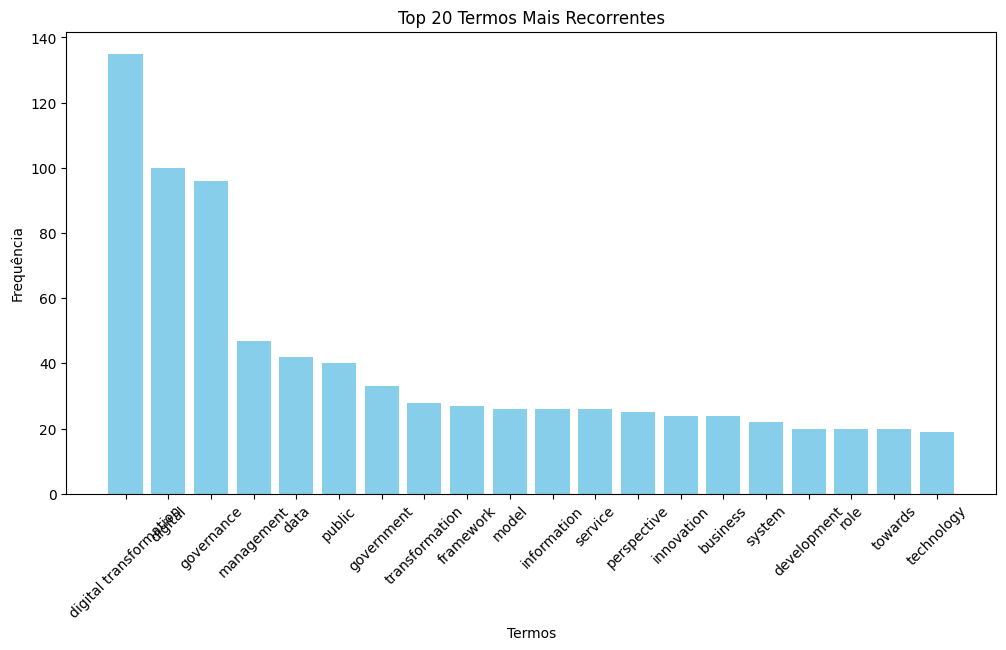

In [ ]:
# Gerar o gráfico de barras para os 20 termos mais recorrentes na coluna 'Title'
plot_top_20_terms(df_compound_terms, 'Title')

### Filtrar coocorrências mais recorrentes

In [ ]:
# Função para filtrar as coocorrências com threshold
def filter_high_cooccurrences(cooc_matrix_df, threshold):
    # Filtrar apenas os pares com valores de coocorrência acima do threshold
    high_cooccurrences = []
    for i in range(len(cooc_matrix_df)):
        for j in range(i + 1, len(cooc_matrix_df)):  # Considerando apenas a metade superior da matriz
            if cooc_matrix_df.iat[i, j] > threshold:
                high_cooccurrences.append((cooc_matrix_df.index[i], cooc_matrix_df.columns[j], cooc_matrix_df.iat[i, j]))

    # Converter a lista de pares em um DataFrame para exibição
    high_cooccurrences_df = pd.DataFrame(high_cooccurrences, columns=["Termo 1", "Termo 2", "Coocorrência"])
    high_cooccurrences_df = high_cooccurrences_df.sort_values(by="Coocorrência", ascending=False).reset_index(drop=True)

    return high_cooccurrences_df

In [ ]:
# Gerar a matriz de coocorrência a partir do DataFrame
# cooc_matrix_df

# Definir um threshold para filtrar as coocorrências mais altas
threshold = 7  # Exemplo: somente coocorrências maiores que 1

# Filtrar e exibir os pares de termos que excedem o threshold
high_cooccurrences_df = filter_high_cooccurrences(cooc_matrix_df, threshold)

# Mostrar o resultado
#import ace_tools as tools; tools.display_dataframe_to_user(name="Pares de Termos com Alta Coocorrência", dataframe=high_cooccurrences_df)


In [ ]:
high_cooccurrences_df

,Termo 1,Termo 2,Coocorrência
0,digital,transformation,166
1,digital,governance,71
2,governance,transformation,45
3,digital,government,30
4,digital,public,28
...,...,...,...
82,governance,process,8
83,business,governance,8
84,company,digital,8
85,government,project,8


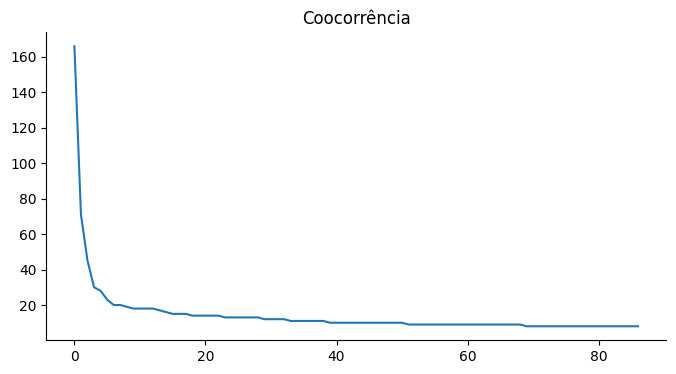

In [ ]:
# @title Coocorrência

from matplotlib import pyplot as plt
high_cooccurrences_df['Coocorrência'].plot(kind='line', figsize=(8, 4), title='Coocorrência')
plt.gca().spines[['top', 'right']].set_visible(False)

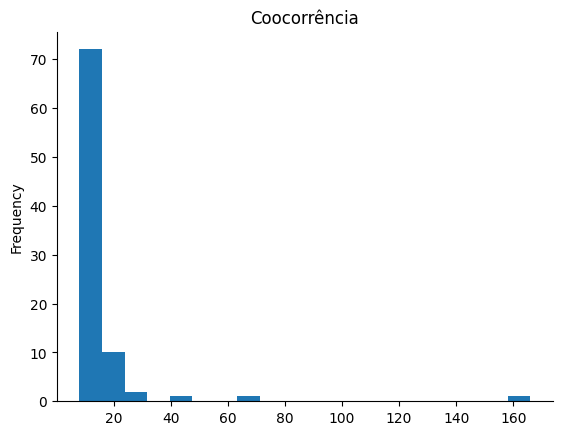

In [ ]:
# @title Coocorrência

from matplotlib import pyplot as plt
high_cooccurrences_df['Coocorrência'].plot(kind='hist', bins=20, title='Coocorrência')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def restore_compound_terms_in_place(tokens, compound_terms):
    """
    Restaura termos compostos na lista original de tokens.

    Parâmetros:
    - tokens: lista de tokens (ex.: ['big', 'data', 'is', 'important'])
    - compound_terms: lista de termos compostos para restaurar (ex.: ['big data', 'machine learning', 'transformação digital'])

    Retorna:
    - Lista de tokens com os termos compostos restaurados, modificando a lista original.
    """

    # Criar um dicionário para mapear cada termo composto para sua lista de palavras
    compound_dict = {tuple(term.split()): term for term in compound_terms}

    i = 0
    while i < len(tokens):
        # Tentar formar termos compostos usando a lista de tokens subsequentes
        match_found = False
        for compound_words in compound_dict.keys():
            if tokens[i:i+len(compound_words)] == list(compound_words):
                # Substituir os tokens que formam o termo composto pelo termo composto original
                tokens[i:i+len(compound_words)] = [compound_dict[compound_words]]
                match_found = True
                break
        # Avançar o índice
        i += 1 if not match_found else len(compound_words)

    return tokens

# Exemplo de uso
tokens = ["big", "data", "is", "important", "for", "machine", "learning", "and", "transformação", "digital"]
compound_terms = ["big data", "machine learning", "transformação digital"]

# Restaurar termos compostos diretamente na lista original
restored_tokens = restore_compound_terms_in_place(tokens, compound_terms)
print("Tokens com termos compostos restaurados:", restored_tokens)


Tokens com termos compostos restaurados: ['big data', 'is', 'important', 'for', 'machine learning', 'and', 'transformação digital']


In [ ]:
import pandas as pd

# Exemplo de DataFrame com uma coluna de tokens
data = {
    'Title': [
        ["big", "data", "is", "important", "for", "machine", "learning"],
        ["transformação", "digital", "and", "innovation"],
        ["big", "data", "and", "machine", "learning", "are", "key"],
        ["society", "depends", "on", "transformação", "digital"]
    ]
}
df = pd.DataFrame(data)

# Função para restaurar termos compostos in-place
def restore_compound_terms_in_place(tokens, compound_terms):
    compound_dict = {tuple(term.split()): term for term in compound_terms}
    i = 0
    while i < len(tokens):
        match_found = False
        for compound_words in compound_dict.keys():
            if tokens[i:i+len(compound_words)] == list(compound_words):
                tokens[i:i+len(compound_words)] = [compound_dict[compound_words]]
                match_found = True
                break
        i += 1 if not match_found else len(compound_words)
    return tokens

# Lista de termos compostos para restaurar
compound_terms = ["big data", "machine learning", "transformação digital"]

# Aplicar a função a cada registro do DataFrame
df['Title'] = df['Title'].apply(lambda tokens: restore_compound_terms_in_place(tokens, compound_terms))

# Mostrar o DataFrame com os termos compostos restaurados
print("DataFrame com termos compostos restaurados:\n", df)


DataFrame com termos compostos restaurados:
                                               Title
0  [big data, is, important, for, machine learning]
1          [transformação digital, and, innovation]
2       [big data, and, machine learning, are, key]
3     [society, depends, on, transformação digital]


### Mapa de Calor
Ainda não deu muito certo

In [ ]:
import seaborn as sns
# Função para plotar o mapa de calor de coocorrência
def plot_cooccurrence_heatmap(cooc_matrix_df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cooc_matrix_df, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5, cbar=True)
    plt.title("Mapa de Calor das Coocorrências de Termos")
    plt.xlabel("Termos")
    plt.ylabel("Termos")
    plt.show()

In [ ]:
# Plotar o mapa de calor da matriz de coocorrência
plot_cooccurrence_heatmap(cooc_matrix_df)

### Dendograma

melhorar a entrada do texto: precisa adaptar de Dataframe para texto, ou fazer a função aceitar a coluna do Dataframe

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

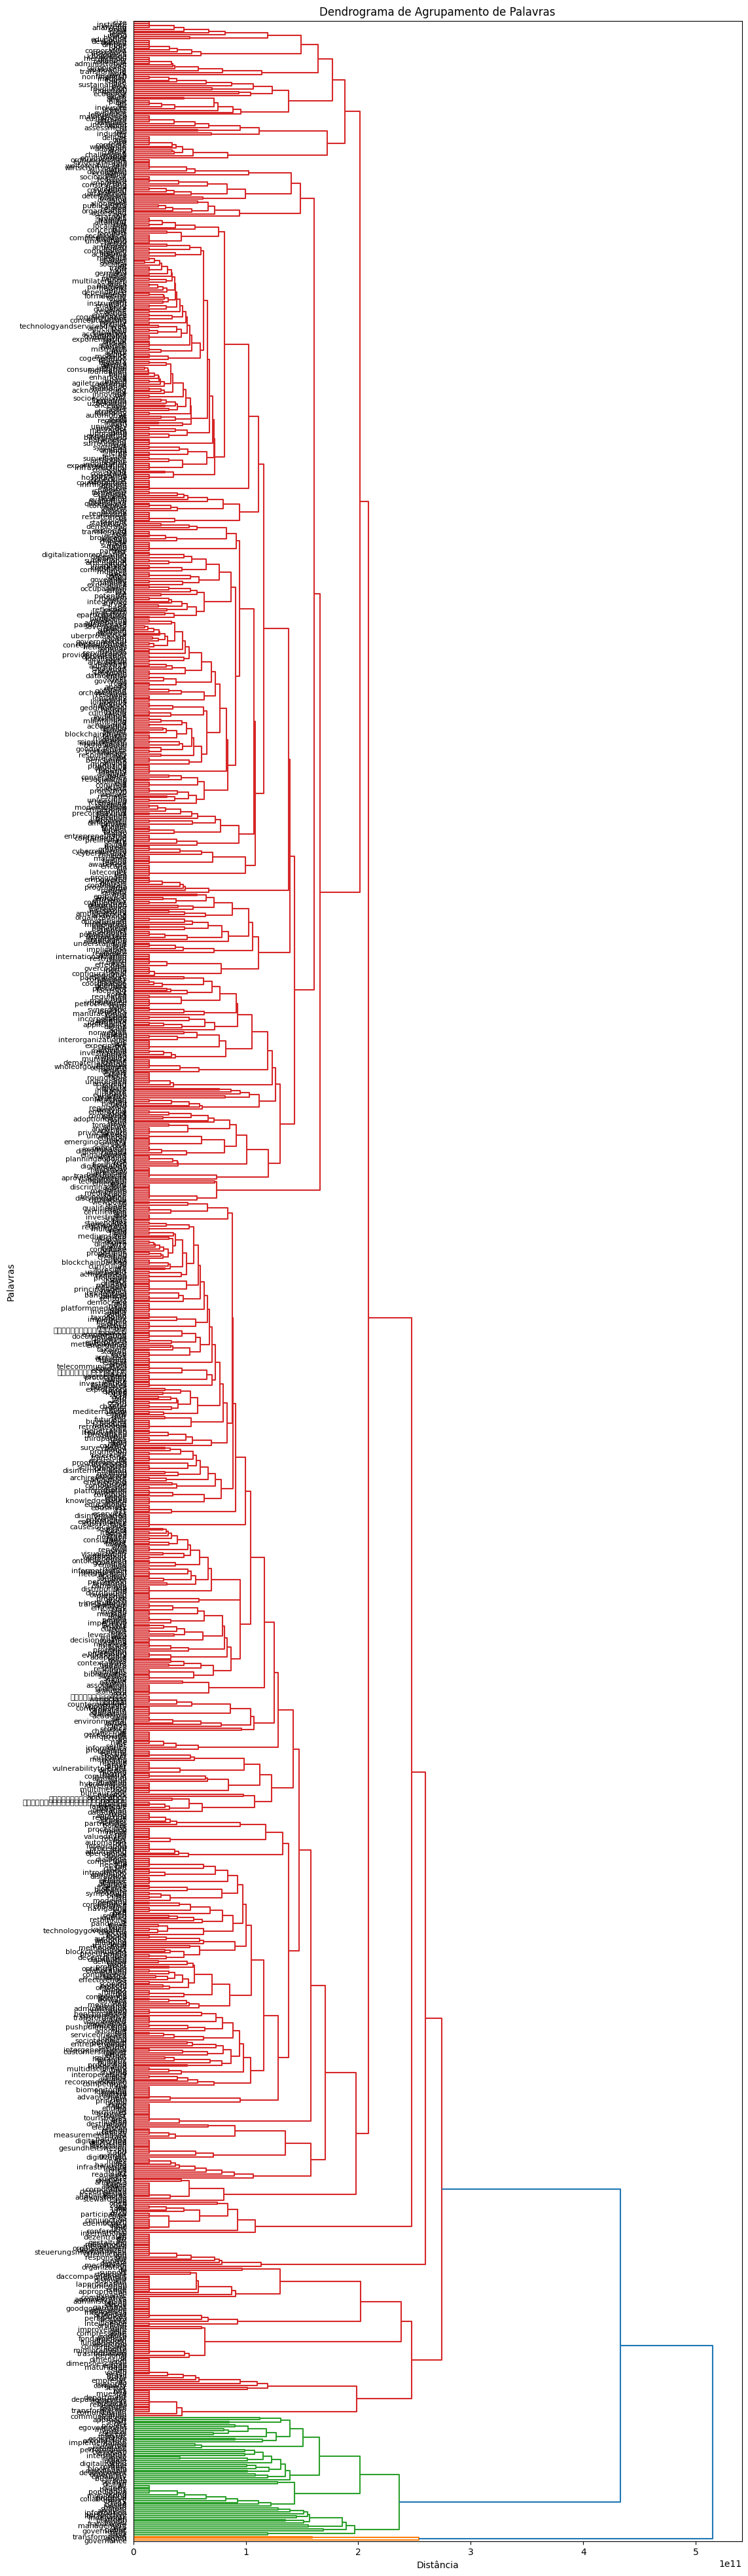

In [ ]:
# Função para plotar o dendrograma de palavras
def plot_word_dendrogram(cooc_matrix_df):
    # Converter a matriz de coocorrência em uma matriz de distância (inverso da coocorrência)
    distance_matrix = 1 / (cooc_matrix_df + 1e-10)  # Pequeno valor para evitar divisão por zero

    # Executar o agrupamento hierárquico
    linkage_matrix = linkage(distance_matrix, method='ward')

    # Plotar o dendrograma
    plt.figure(figsize=(12, 50))
    dendrogram(linkage_matrix, labels=cooc_matrix_df.index, orientation='right', leaf_font_size=8)
    plt.title("Dendrograma de Agrupamento de Palavras")
    plt.xlabel("Distância")
    plt.ylabel("Palavras")
    plt.show()

# Plotar o dendrograma de palavras
plot_word_dendrogram(cooc_matrix_df)
